# Cars/Trucks Scraper

This tool scrapes car and truck postings from craigslist and returns a data frame that can be analyzed and visualized

In [73]:
from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

# define car and truck query function
def CarsTrucksPrices(url, query_text = '', zip_code = '', search_distance = ''):
    """
    Note: You can either paste the full request url or use the parameters
    query_text = text that you want to search for. e.g. "Subaru"
    zip_code = target zip code for query
    search_distance = search radius in miles for the query e.g. 11.5
    """

    
    if zip_code is not None:
        zip_code = 'postal=' + str(zip_code)
        
    if query_text is not None:
        query_text = '&query=' + str(query_text)
        query_text = query_text.replace(' ', '+')
        
    if search_distance is not None:
        search_distance = '&search_distance=' + str(search_distance)
        
    if zip_code is None and query_text is None and search_distance is None:
        full_url = url
    else:
        full_url = url + '?' + zip_code + search_distance + query_text
        
    print('passed url: ', full_url)
        
    from requests import get
    response = requests.get(full_url)

    from bs4 import BeautifulSoup
    html_soup = bs4.BeautifulSoup(response.text, 'html.parser')            

    # find total number of posts
    results_num = html_soup.find('div', class_ = 'search-legend')
    results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

    print('total results: ', results_total)

    #each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
    pages = np.arange(0, results_total+1, 120)
    print('pages: ', len(pages))

    post_titles = []
    post_prices = []
    post_links = []

    for page in pages:

        response = get(full_url + '&s=' + str(page))

        sleep(randint(1,5))

        #throw warning for status codes that are not 200
        if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, response.status_code))

        #define the html text
        page_html = BeautifulSoup(response.text, 'html.parser')

        #define the posts
        posts = page_html.find_all('li', class_= 'result-row')

        #extract data item-wise
        for post in posts:

            #extract elements from each post soup
            title = post.find('a', class_='result-title hdrlnk')
            title_text = title.text
            price = int(post.find('span', class_= 'result-price').text.replace("$","").replace(",",""))
            link = title['href']

            #append results to lists if price greater than zero
            if price > 5:
                post_titles.append(title_text)
                post_prices.append(price)
                post_links.append(link)

    import pandas as pd

    results_df = pd.DataFrame({'Title': post_titles,
                      'Price': post_prices,
                      'Link': post_links})

    results_df = results_df.drop_duplicates(subset='Link')
    
    print("Scrape Successful!")

    return results_df

In [76]:
results = CarsTrucksPrices(url='https://charlottesville.craigslist.org/search/cta', query_text='mazda', zip_code='22903', search_distance='10')
results

passed url:  https://charlottesville.craigslist.org/search/cta?postal=22903&search_distance=10&query=mazda
total results:  7
pages:  1
Scrape Successful!


,Title,Price,Link
0,2016 MAZDA MX5 Miata Club Convertible 2D Conve...,20990,https://charlottesville.craigslist.org/ctd/d/c...
1,2012 MAZDA MAZDA5 SPORT,4500,https://charlottesville.craigslist.org/ctd/d/c...
2,2019 MAZDA MX5 Miata Sport Convertible 2D Conv...,24990,https://charlottesville.craigslist.org/ctd/d/c...
3,2012 MAZDA MAZDA5 SPORT,4500,https://charlottesville.craigslist.org/ctd/d/c...
4,2012 MAZDA MAZDA5 SPORT,4500,https://charlottesville.craigslist.org/ctd/d/c...
5,2000 Dodge Dakota,1999,https://charlottesville.craigslist.org/ctd/d/c...
6,2012 Chrysler 200 new inspection reliable,3495,https://charlottesville.craigslist.org/cto/d/c...


Text(0, 0.5, 'Count')

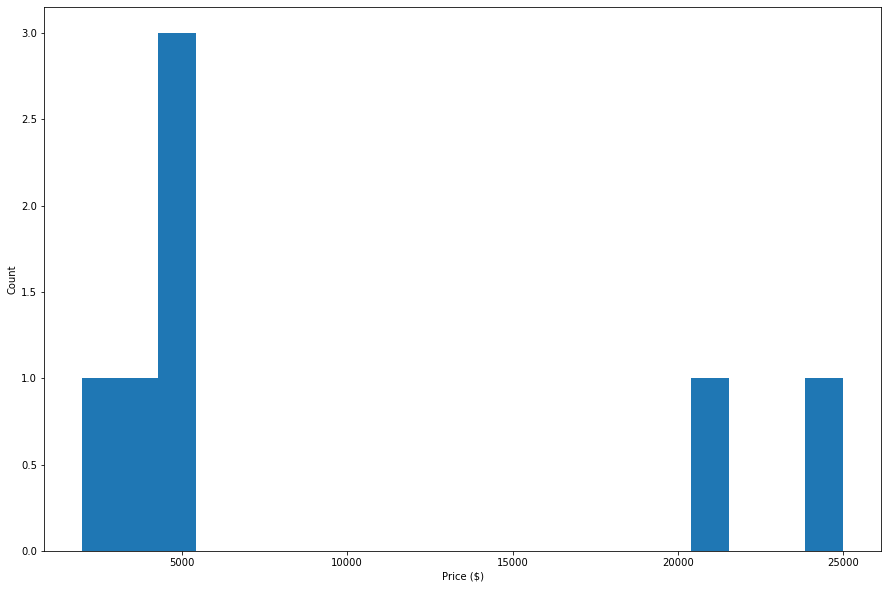

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.hist(results['Price'], bins=20)
plt.xlabel('Price ($)')
plt.ylabel('Count')